In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [64]:
def API_Simulada(nombreDeArchivo): 
    df = pd.read_csv(nombreDeArchivo)

    # queremos convertir la columnas key en columnas dummie
    one_hot = pd.get_dummies(df["key"], prefix="Key", drop_first = True)
    one_hot

    two_hot = pd.get_dummies(df["time_signature"], prefix="time_signature", drop_first=True)
    two_hot

    df_limpio = df.join(one_hot).drop(columns=["key"])
    df_limpio = df_limpio.join(two_hot).drop(columns=["time_signature"])
    
    #Ajustamos los datos de la API
    scaler = StandardScaler()
    columnas = df_limpio.columns.to_list()
    columnas.remove('liked') #Esto solo lo vamos a utilizar en nuestro dataset ya que tiene una columna de mas
    df_limpio[columnas] = scaler.fit_transform(df_limpio[columnas])
       
    return df_limpio
    
def crearDataFrameUsu(API):
    N = 5
    datos = API.sample(N, replace = False)
    if datos["liked"].nunique() != 2:
        datos = crearDataFrameUsu(API)  # Por posibles errores
    return datos

def entrenarDatos(modelo, datosUsuario):
    X_train =  datosUsuario.drop(["liked"], axis=1)
    y_train = datosUsuario["liked"]
    # Preparamos el modelo
    modelo.fit(X_train, y_train)
    return modelo

def busquedaCancion(API, modelo):
    infoCancion = API.sample(1)
    predictCancion = infoCancion.drop(["liked"], axis=1)
    prediccion = modelo.predict(predictCancion)[0]  #Devuelve 0 o 1 si le gusto en una lista
    
    return prediccion, infoCancion
    #Aca le mostramos la cancion con la API Spotify

def agregarCanciones(N, datosUsuario, API, modelo, accuracy):
    modelo = entrenarDatos(modelo, datosUsuario)  #Entrenamos el modelo cuantas veces

    filas = datosUsuario.shape[0]
    while datosUsuario.shape[0] < filas + N:
        prediccion, infoCancion = busquedaCancion(API, modelo)
        if not infoCancion.index[0] in datosUsuario.index:
            if prediccion == 1:
                datosUsuario = datosUsuario.append(infoCancion, ignore_index = False)
                modelo = entrenarDatos(modelo, datosUsuario)  #Entrenamos el modelo cuantas veces
                accuracy.append(accuracyMetrica(datosUsuario, modelo))
                       
    return datosUsuario

def metricaLiked(datosUsuario):
    n = datosUsuario.shape[0]
    x = list(range(1, n + 1))
    y = datosUsuario["liked"]
    y = np.cumsum(y)
    plt.title('Metrcias Liked')
    plt.xlabel('Canciones')
    plt.ylabel('Liked')
    sns.lineplot(x = x,y = y)
    sns.lineplot(x = x,y = x)

def accuracyMetrica(datosUsuario, modelo):
    if (datosUsuario["liked"] == 0).sum() < 2: return
    if (datosUsuario["liked"] == 1).sum() < 2: return
    X_train, X_test, y_train, y_test = train_test_split(datosUsuario.drop(["liked"], axis=1), datosUsuario["liked"], test_size = 0.5, stratify=datosUsuario["liked"])
    modelo.fit(X_train, y_train)
    # Buscamos la predicciones y su probabilidad
    y_pred = modelo.predict(X_test)
    n = datosUsuario.shape[0]
    ac = accuracy_score(y_test, y_pred)
    nula = datosUsuario["liked"].sum() / datosUsuario.shape[0]
    return ac, nula, n

def printAccuracy(ac):
    accuracy  = []
    hipotesisNula = []
    n = []
    for a in ac:
        if not a is None:
            accuracy.append(a[0])
            hipotesisNula.append(a[1])
            n.append(a[2])
    plt.title('Metrcias Accuary')
    plt.xlabel('Data Set')
    plt.ylabel('Accuracy')
    sns.lineplot(x = n, y = accuracy)
    sns.lineplot(x = n, y = hipotesisNula)
    
    

# Main


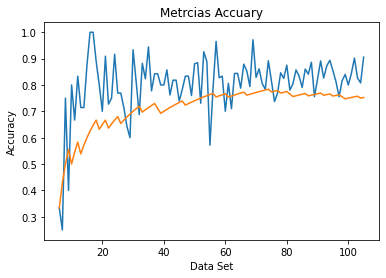

In [79]:
API = API_Simulada("data.csv")      # Añadimos el DataSet
datosUsuario = crearDataFrameUsu(API) 

# Vamos a ejecutar el modelo
clf = LogisticRegression(C=1e10)
clf = entrenarDatos(clf, datosUsuario)

accuracy = []
datosUsuario = agregarCanciones(100, datosUsuario, API, clf, accuracy)  # No mas de 100 canciones

printAccuracy(accuracy)    #   Metrica del Acurracy con Hipotesis Nula



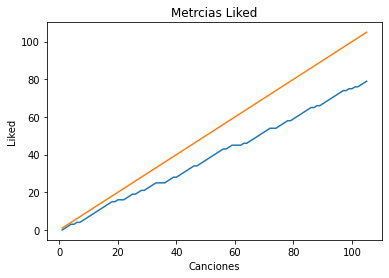

In [78]:
metricaLiked(datosUsuario)